In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")

Veriyi Dahil Etme

In [2]:
class veri(Dataset): #dataset classı pytorch un veriyi eklemek için kullandırttığı bir classdır.
    def __init__(self, csv_file, root_dir, transform=None): #csv_file fotograflarımızın adreslerinin yer aldığı dosyadır onun pathini vermemiz gerekiyor. root_dir fotograflarımızın oldugu klasörün adresidir
        self.annotations=pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
       img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
       image=io.imread(img_path)
       y_label=torch.tensor(int(self.annotations.iloc[index,1]))
       
       if self.transform:
              image=self.transform(image)
              return (image,y_label)

Veriyi Hazırlama

In [3]:
dataset=veri(csv_file="D:\\udemy_data\\f1_classification\\f111.csv",root_dir="D:\\udemy_data\\f1_classification",
transform=torchvision.transforms.Compose([ #compose metodu birden fazla transform işlemini tek seferde yapmamıza olanak tanır.
    transforms.ToTensor(), #tensore cevirmemizi sağlar verimizi
    transforms.Resize(size=(28,28)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

Veri Ön İşleme

In [4]:
train_set,test_set=torch.utils.data.random_split(dataset,[200,79]) # verimizin 200 ü train geri kalan 79 tanesi test için ayrıldı
train_loader=DataLoader(dataset=train_set,batch_size=1,shuffle=False)
test_loader=DataLoader(dataset=test_set,batch_size=1,shuffle=False)

Veriyi Görselleştirme

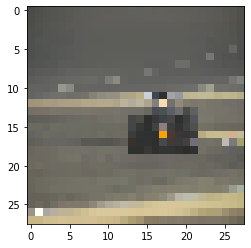

Redbull
torch.Size([1, 3, 28, 28])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
batch_size=1
classes=["Ferrari","Mclaren","Mercedes","Redbull"]

def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
dataiter=iter(train_loader)
images,labels=dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("".join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())



Model Mimarisini Oluşturma

In [6]:
class Net(nn.Module): #model yapısı class içinde oluşturulur ilk 3 satır pytochda class için temel tanımlamalardır.
    def __init__(self):
        super(Net,self).__init__()
        #conv katmanları:
        self.conv1=nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5)) #giriş kanalı, çıkış kanalı ve kernel size ı tanımladık atride(adım) gibi tanımlamaları default değerde bıraktık.
        self.conv2=nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3))
        self.conv3=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2))
        self.conv4=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2))
        #max pooling katmanı:

        self.max=nn.MaxPool2d(kernel_size=(2,2)) # bu katman her conv dan sonra çalışıcak bağlama kısmında belirtiyoruz. Buraya birden fazla maxpool fonksiyonu tanımlayıp bağlama fonksiyonunda onlarıda kullanabiliriz.

        #aktivasyon fonksiyonu:
        self.func=nn.ELU()

        #fully connected laerımız: ("tensorflowda dense diye geçiyor")
        self.fc1=nn.Linear(in_features=32,out_features=50) #conv katmanından en son 32 kanal çıktıgı için girişi 32 ile başlattık.
        self.fc2=nn.Linear(in_features=50,out_features=50)
        self.fc3=nn.Linear(in_features=50,out_features=100)
        self.fc4=nn.Linear(in_features=100,out_features=4) # son çıktı katmanımız 4 formula aracı oldugu için 4 çıkışlı yaptık.

    def forward(self,x): # bu fonksiyon bağlama fonksiyonudur oluşturdugumuz katmanlar birbirine bağlı değil bu fonksiyon ile bağlama işlmeini geçekleştiriyoruz.
         x=self.conv1(x) #conv katmanının çıkışını aktivasyon fonksiyonuna onuda maxpool a gönderiyoruz sonuncu conv katmanının çıkışında maxpool yok
         x=self.func(x)
         x=self.max(x)

         x=self.conv2(x)
         x=self.func(x)
         x=self.max(x)

         x=self.conv3(x)
         x=self.func(x)
         x=self.max(x)

         x=self.conv4(x)
         x=self.func(x)

         x=x.view(x.size(0),-1) #flatten: düzleştirme işlemi

         x=self.fc1(x)
         x=self.func(x)
         x=self.fc2(x)
         x=self.func(x)
         x=self.fc3(x)
         x=self.func(x)
         x=self.fc4(x)
            
         return x
          




Modelin Eğitimi

In [ ]:
#tensorflowda fit metoduyla yaptıgımız işlem.

start=time.time() # zamınımızı tutacak yapmasakta olur

model=Net() # yukarda tanımladıgımız classı çağırıyoruz

optimizer=torch.optim.Adamax(model.parameters(),lr=0.001) #optimizasyon fonksiyonumuzu belirliyoruz. İçerisine modelimizin parametrelerini ve learning rate değerimizi giriyoruzki ağırlıkları güncelleyebilsin.

error=torch.nn.CrossEntropyLoss() #loss fonksiyonumuzu belirledik

epoch = 10

for j in range(epoch):
    for i,(images,label) in enumerate (train_loader):

        optimizer.zero_grad() # her bir epoch sonunda türev değerlini sıfırlıyor. Ağırlıklara göre her bir epocta yeni bir türev değeri hesaplıyor.
        tahmin=model(images)
        loss=error(tahmin,label)
        loss.backward() # kayıp değerine göre geri yayılımı uyguluyoruz.
        optimizer.step() #zero_grad, backward ve step fonksiyonları olmazla olmaz fonksiyonlar. step sonraki adıma geçmemizi sağlıyor.

        print("Epoch [{}/{}],loss:{:.4f}".format(j+1,i+1,loss.item()))
end=time.time()
print("süre:",end-start)



Model Testi

In [12]:

def dogruluk(loader,model):
    num_correct=0
    num_samples=0
    model.eval()#modeli test edicez

    with torch.no_grad(): #burda modelimizi eğitmediğimiz için türevleri hesaplatmıcaz
        for x,y in loader:
            tahmin=model(x)
            _,pred=tahmin.max(1)
            num_correct+=(pred==y).sum() #tahmin değerimizi y' ye eşitse correcti 1 artıracak
            num_samples+=pred.size(0)
            
        print(f"Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        model.train()



In [ ]:
print("train dogruluk:")
dogruluk(train_loader,model)
print("test dogruluk:")
dogruluk(test_loader,model)


Modelin Eğitimi ve Testi

In [7]:
# bu kısımda model eğitilirken aynı zamanda testide yaptıgımız kısımdır. Bu aşamayı kullanırken önceki iki aşamaya gerek kalmıyor.

start=time.time() 

model=Net() 

optimizer=torch.optim.Adam(model.parameters(),lr=0.001) 

error=torch.nn.CrossEntropyLoss() 

epoch = 10

kayıp=[] #loss bilgimizi eklicez
count=0
iterasyon=[] #iterasyonları buna eklicez
for i in range(epoch):
    for i,(images,label) in enumerate(train_loader):
        tahmin=model(images)
        optimizer.zero_grad()
        loss=error(tahmin,label)
        loss.backward()
        optimizer.step()

        count+=1

        if count % 100 == 0:
            total=0
            correct=0
            correct_hata=0
            for image,labels in test_loader:
                out=model(image)
                pred=torch.max(out.data,1)[1]
                total+=len(label)

                correct+=(pred==labels).sum() #doğru sayımız
                correct_hata+=(pred!=labels).sum() # yanlış sayımız
            dogruluk=100*correct/float(total)
            hata=100*correct_hata/float(total)

            kayıp.append(loss.data)
            iterasyon.append(count)

        if count % 100 == 0:
            print('Iteration: {} loss: {} accuracy: {:.2f}% Error: {:.2f}%'.format(count,loss.data,dogruluk,hata))


        

end=time.time()
print("süre:",end-start)

Iteration: 100 loss: 1.390954613685608 accuracy: 16.46% Error: 83.54%
Iteration: 200 loss: 1.5441118478775024 accuracy: 27.85% Error: 72.15%
Iteration: 300 loss: 0.7905310988426208 accuracy: 39.24% Error: 60.76%
Iteration: 400 loss: 1.4495091438293457 accuracy: 49.37% Error: 50.63%
Iteration: 500 loss: 0.0323810912668705 accuracy: 45.57% Error: 54.43%
Iteration: 600 loss: 3.5103936195373535 accuracy: 58.23% Error: 41.77%
Iteration: 700 loss: 0.020217301324009895 accuracy: 64.56% Error: 35.44%
Iteration: 800 loss: 2.6213319301605225 accuracy: 55.70% Error: 44.30%
Iteration: 900 loss: 0.005862067453563213 accuracy: 67.09% Error: 32.91%
Iteration: 1000 loss: 1.6670043468475342 accuracy: 58.23% Error: 41.77%
Iteration: 1100 loss: 0.0029882797971367836 accuracy: 73.42% Error: 26.58%
Iteration: 1200 loss: 1.4881958961486816 accuracy: 58.23% Error: 41.77%
Iteration: 1300 loss: 0.004507737699896097 accuracy: 74.68% Error: 25.32%
Iteration: 1400 loss: 0.6529662013053894 accuracy: 68.35% Error: 

Model Save

In [8]:
torch.save(model,"udemy1.pth") #modeli kaydetme
torch.save(model.state_dict(),"udemy11.pth") #modelin sadece ağırlıklarını kaydetme

Model Load

In [9]:
model1=torch.load("udemy1.pth")

In [10]:
model11=Net() #ağırlıkları kullanarak laod etme (tekrar classımızı çağırıp eval ile modeli çağırıyoruz)
model11.load_state_dict(torch.load("udemy11.pth"))
model11.eval()


Net(
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (max): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (func): ELU(alpha=1.0)
  (fc1): Linear(in_features=32, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=4, bias=True)
)

In [13]:
print("train dogruluk:")
dogruluk(train_loader,model1)
print("test dogruluk:")
dogruluk(test_loader,model1)

train dogruluk:
Got 183/200 with accuracy 91.50
test dogruluk:
Got 62/79 with accuracy 78.48


Summary(Özet)

In [14]:
from torchsummary import summary
summary(model,input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 24, 24]             304
               ELU-2            [-1, 4, 24, 24]               0
         MaxPool2d-3            [-1, 4, 12, 12]               0
            Conv2d-4            [-1, 8, 10, 10]             296
               ELU-5            [-1, 8, 10, 10]               0
         MaxPool2d-6              [-1, 8, 5, 5]               0
            Conv2d-7             [-1, 16, 4, 4]             528
               ELU-8             [-1, 16, 4, 4]               0
         MaxPool2d-9             [-1, 16, 2, 2]               0
           Conv2d-10             [-1, 32, 1, 1]           2,080
              ELU-11             [-1, 32, 1, 1]               0
           Linear-12                   [-1, 50]           1,650
              ELU-13                   [-1, 50]               0
           Linear-14                   

Loss Görselleştirme

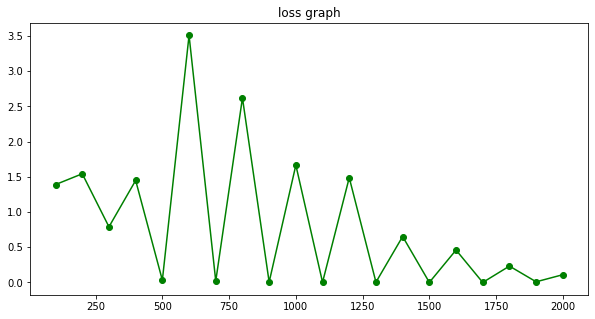

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("loss graph")
plt.plot(iterasyon,kayıp,"-o",color="g")

plt.xlabel=("iterasyon")
plt.ylabel=("loss")

plt.show()

Test Verisinden Tahmin

In [16]:
clas_name=["Ferrari","Mclaren","Mercedes","Redbull"]

In [25]:
def görsellestirme(model,image_sayısı=6):
    was_training=model.training
    model.eval()
    resim_sayısı=0
    with torch.no_grad():
        for i,(image,labels) in enumerate (test_loader):
            output=model(image)
            _,tahmin=torch.max(output,1)

            for j in range (image.size()[0]):
                plt.figure(figsize=(40,30))
                resim_sayısı+=1
                ax=plt.subplot(image_sayısı//2,2,resim_sayısı)
                ax.axis("off")
                ax.set_title("Tahmin: {}".format(clas_name[tahmin[j]]))
                imshow(image.cpu().data[j])

                if resim_sayısı==image_sayısı:
                    model.train(mode=was_training)
                    return

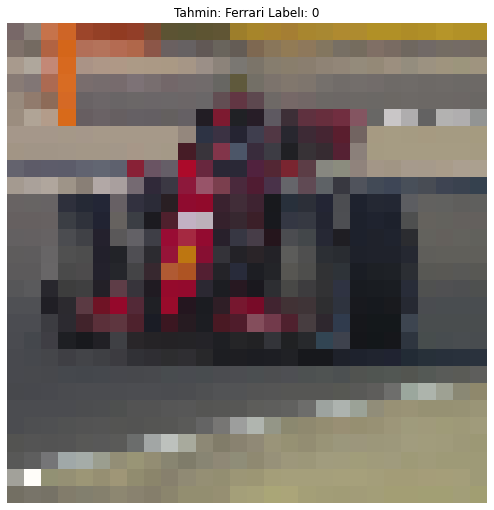

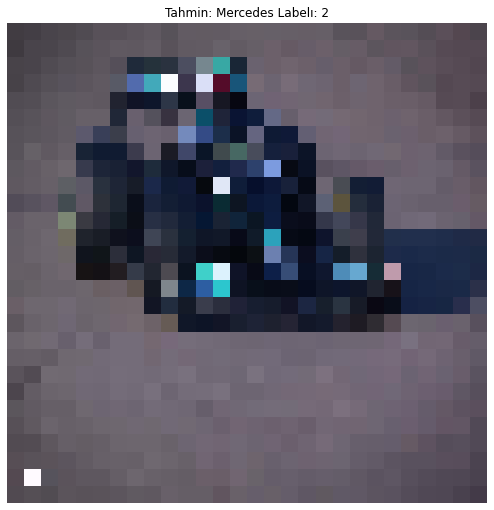

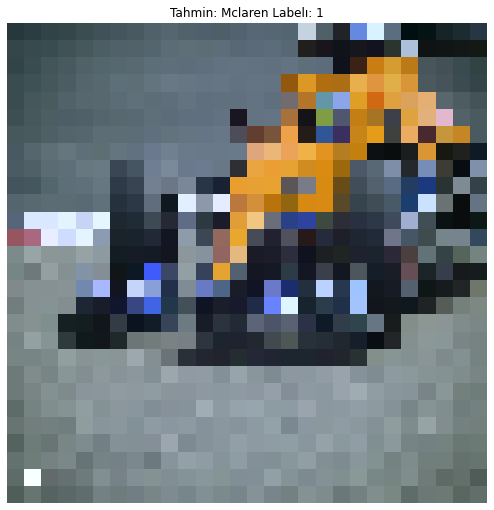

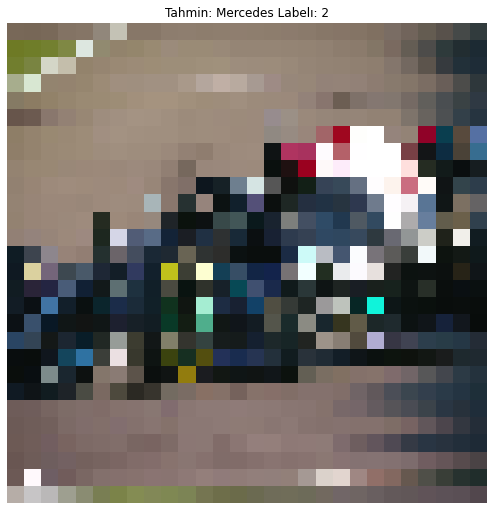

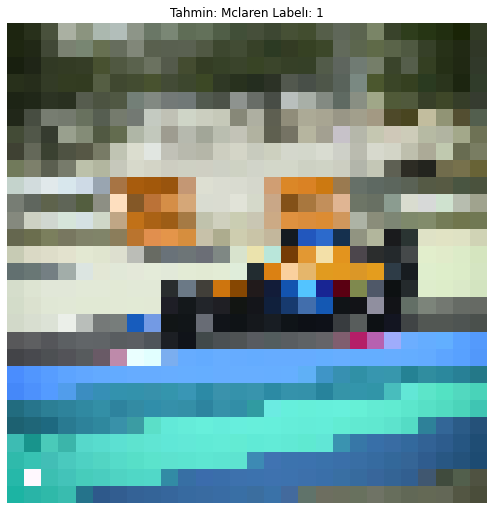

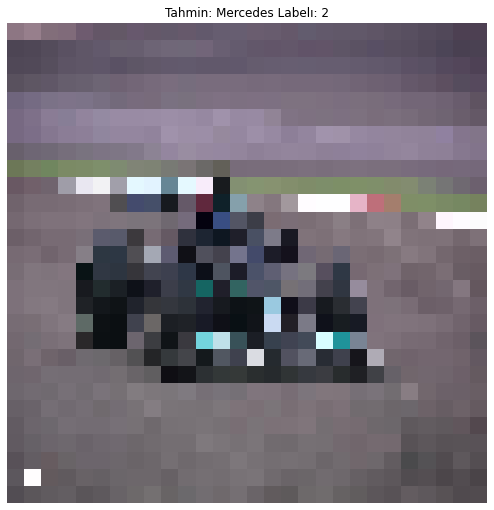

In [26]:
görsellestirme(model)